In [2]:
%pip install jmetalpy

     |████████████████████████████████| 112kB 8.3MB/s 
  Created wheel for jmetalpy: filename=jmetalpy-1.5.5-cp36-none-any.whl size=196215 sha256=1824358b4bbc2c586a08e1bb2cd0910d877454a7ffed26f60a9e77deb62ddf89
  Stored in directory: /root/.cache/pip/wheels/d0/ae/f5/6493b2f72d1311cf8f97e283039fb225f4743879bd04345a9e
Successfully built jmetalpy


In [3]:
%pip install scikit-posthocs

In [4]:
from jmetal.algorithm.singleobjective.local_search import LocalSearch
from jmetal.operator import SimpleRandomMutation
from jmetal.problem.singleobjective.unconstrained import Sphere, Rastrigin
from jmetal.util.solution import print_function_values_to_file, print_variables_to_file
from jmetal.util.termination_criterion import StoppingByEvaluations
from jmetal.algorithm.singleobjective.genetic_algorithm import GeneticAlgorithm
from jmetal.operator import BinaryTournamentSelection, PolynomialMutation, SBXCrossover, UniformMutation
from jmetal.problem.singleobjective.unconstrained import Rastrigin
from jmetal.util.termination_criterion import StoppingByEvaluations
import matplotlib.pyplot as plt 
import numpy as np

In [5]:
import copy
import random
from typing import List

from jmetal.core.operator import Crossover
from jmetal.core.solution import Solution, FloatSolution, BinarySolution, PermutationSolution, IntegerSolution, \
    CompositeSolution
from jmetal.util.ckecking import Check
from jmetal.util.observer import VisualizerObserver,Plot, BasicObserver, PlotFrontToFileObserver
from jmetal.core.problem import FloatProblem, FloatSolution
from math import sqrt, sin
import math
import numpy

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# jmetal crossover


class DifferentialEvolutionCrossover(Crossover[FloatSolution, FloatSolution]):
    """ This operator receives two parameters: the current individual and an array of three parent individuals. The
    best and rand variants depends on the third parent, according whether it represents the current of the "best"
    individual or a random_search one. The implementation of both variants are the same, due to that the parent selection is
    external to the crossover operator.
    """

    def __init__(self, CR: float, F: float, K: float):
        super(DifferentialEvolutionCrossover, self).__init__(probability=1.0)
        self.CR = CR
        self.F = F
        self.K = K

        self.current_individual: FloatSolution = None

    def execute(self, parents: List[FloatSolution]) -> List[FloatSolution]:
        """ Execute the differential evolution crossover ('best/1/bin' variant in jMetal).
        """
        if len(parents) != self.get_number_of_parents():
            raise Exception('The number of parents is not {}: {}'.format(self.get_number_of_parents(), len(parents)))

        child = copy.deepcopy(self.current_individual)
        if(child == None):
          child = copy.deepcopy(parents[0])

        number_of_variables = parents[0].number_of_variables
        rand = random.randint(0, number_of_variables - 1)

        for i in range(number_of_variables):
            if random.random() < self.CR or i == rand:
                value = parents[2].variables[i] + self.F * (parents[0].variables[i] - parents[1].variables[i])

                if value < child.lower_bound[i]:
                    value = child.lower_bound[i]
                if value > child.upper_bound[i]:
                    value = child.upper_bound[i]
            else:
                value = child.variables[i]

            child.variables[i] = value
        
        self.current_individual = child
        return [child]


    def get_number_of_parents(self) -> int:
        return 3


    def get_number_of_children(self) -> int:
        return 1


    def get_name(self) -> str:
        return 'Differential Evolution crossover'

In [18]:
from statistics import mean 

class SelectiveMultiParentCrossover(Crossover[FloatSolution, FloatSolution]):

    def __init__(self, CR: float, F: float, K: float = 0.5, PN: int = 3):
        super(SelectiveMultiParentCrossover, self).__init__(probability=1.0)
        self.CR = CR
        self.F = F
        self.K = K
        self.PN =PN

        self.current_individual: FloatSolution = None

    def execute(self, parents: List[FloatSolution]) -> List[FloatSolution]:
        """ Execute the differential evolution crossover ('best/1/bin' variant in jMetal).
        """
        if len(parents) != self.get_number_of_parents():
            raise Exception('The number of parents is not {}: {}'.format(self.get_number_of_parents(), len(parents)))

        child = copy.deepcopy(self.current_individual)
        if(child == None):
          child = copy.deepcopy(parents[0])

          
        number_of_variables = parents[0].number_of_variables
        rand = random.randint(0, number_of_variables - 1)

        parents_sample = random.sample(parents, 3)

        for i in range(number_of_variables):
            if random.random() < self.CR or i == rand:
                value1 = parents[0].variables[i] + self.F * (parents[1].variables[i] - parents[2].variables[i])
                value2 = parents[1].variables[i] + self.F * (parents[2].variables[i] - parents[0].variables[i])
                value3 = parents[2].variables[i] + self.F * (parents[0].variables[i] - parents[1].variables[i])

                value = mean([value1, value2, value3])

                if value < child.lower_bound[i]:
                    value = child.lower_bound[i]
                if value > child.upper_bound[i]:
                    value = child.upper_bound[i]
            else:
                value = child.variables[i]

            child.variables[i] = value

        self.current_individual = child
        return [child]

    def get_number_of_parents(self) -> int:
        if self.PN > 10:
            return 10
        if self.PN < 3:
            return 3
        return self.PN

    def get_number_of_children(self) -> int:
        return 1

    def get_name(self) -> str:
        return 'SelectiveMultiParentCrossover'

In [9]:
from random import randrange
class RandomMultiParentCrossoverWithStep(Crossover[FloatSolution, FloatSolution]):

    def __init__(self, PN: int = 3):
        super(RandomMultiParentCrossoverWithStep, self).__init__(probability=1.0)
        self.PN =PN

        self.current_individual: FloatSolution = None

    def execute(self, parents: List[FloatSolution]) -> List[FloatSolution]:
        if len(parents) != self.get_number_of_parents():
            raise Exception('The number of parents is not {}: {}'.format(self.get_number_of_parents(), len(parents)))

        child = copy.deepcopy(self.current_individual)
        if(child == None):
          child = copy.deepcopy(parents[0])
          
        number_of_variables = parents[0].number_of_variables

        for i in range(number_of_variables):
            parent = random.sample(parents, 1)[0]
            selectionLen = randrange(number_of_variables)
            if i + selectionLen >  number_of_variables - 1 :
                selectionLen = number_of_variables - i
            child.variables[i:(i+selectionLen-1)] = parent.variables[i:(i+selectionLen-1)]
            i += selectionLen
        self.current_individual = child
        return [child]

    def get_number_of_parents(self) -> int:
        return self.PN

    def get_number_of_children(self) -> int:
        return 1

    def get_name(self) -> str:
        return 'RandomMultiParentCrossoverWithStep'

In [10]:
from random import randrange
class RandomMultiParentCrossover(Crossover[FloatSolution, FloatSolution]):

    def __init__(self, PN: int = 3):
        super(RandomMultiParentCrossover, self).__init__(probability=1.0)
        self.PN =PN

        self.current_individual: FloatSolution = None

    def execute(self, parents: List[FloatSolution]) -> List[FloatSolution]:
        if len(parents) != self.get_number_of_parents():
            raise Exception('The number of parents is not {}: {}'.format(self.get_number_of_parents(), len(parents)))

        child = copy.deepcopy(self.current_individual)
        if(child == None):
          child = copy.deepcopy(parents[0])
          
        number_of_variables = parents[0].number_of_variables

        for i in range(number_of_variables):
            parent = random.sample(parents, 1)[0]
            child.variables[i] = parent.variables[i]
            i += i
        self.current_individual = child
        return [child]

    def get_number_of_parents(self) -> int:
        return self.PN

    def get_number_of_children(self) -> int:
        return 1

    def get_name(self) -> str:
        return 'RandomMultiParentCrossover'

In [11]:
from jmetal.core.observer import Observer
class DataObserver(Observer):

    def __init__(self, frequency: float = 1.0, data = []) -> None:
        """ Show the number of evaluations, best fitness and computing time.
        :param frequency: Display frequency. """
        self.display_frequency = frequency
        self.data = data

    def update(self, *args, **kwargs):
        computing_time = kwargs['COMPUTING_TIME']
        evaluations = kwargs['EVALUATIONS']
        solutions = kwargs['SOLUTIONS']

        if (evaluations % self.display_frequency) == 0 and solutions:
            if type(solutions) == list:
                fitness = solutions[0].objectives
            else:
                fitness = solutions.objectives
            self.data.append(fitness[0])

In [12]:
from scipy import stats
import scikit_posthocs as sp

problem = Rastrigin(50)


def evaluate(crosssover_algo):
  alldata = []
  for x in range(10):
    algorithm = GeneticAlgorithm(
        problem=problem,
        population_size=100,
        offspring_population_size=100,
        mutation=PolynomialMutation(1.0 / problem.number_of_variables, 20.0),
        crossover=crosssover_algo,
        selection=BinaryTournamentSelection(),
        termination_criterion=StoppingByEvaluations(max_evaluations=50000)
    )
    data = []
    dataobserver = DataObserver(1.0, data)
    algorithm.observable.register(observer=dataobserver)
    algorithm.run()
    alldata.append(data)

  #transpose!
  numpy_array = np.array(alldata)
  transpose = numpy_array.T
  transpose_list = transpose.tolist()

  # print(transpose_list)

    
  fig = plt.figure(figsize =(60, 42)) 
    
  # Creating axes instance 
  ax = fig.add_axes([0, 0, 1, 1]) 
    
  # Creating plot 
  bp = ax.boxplot(transpose_list) 
  
  # show plot 
  plt.show()

  # perform Kruskal-Wallis Test 
  print(stats.kruskal(transpose_list[0],transpose_list[1],transpose_list[-1]))


  # perform dunn test
  sp.posthoc_dunn([transpose_list[0],transpose_list[1],transpose_list[-1]], p_adjust = 'holm')

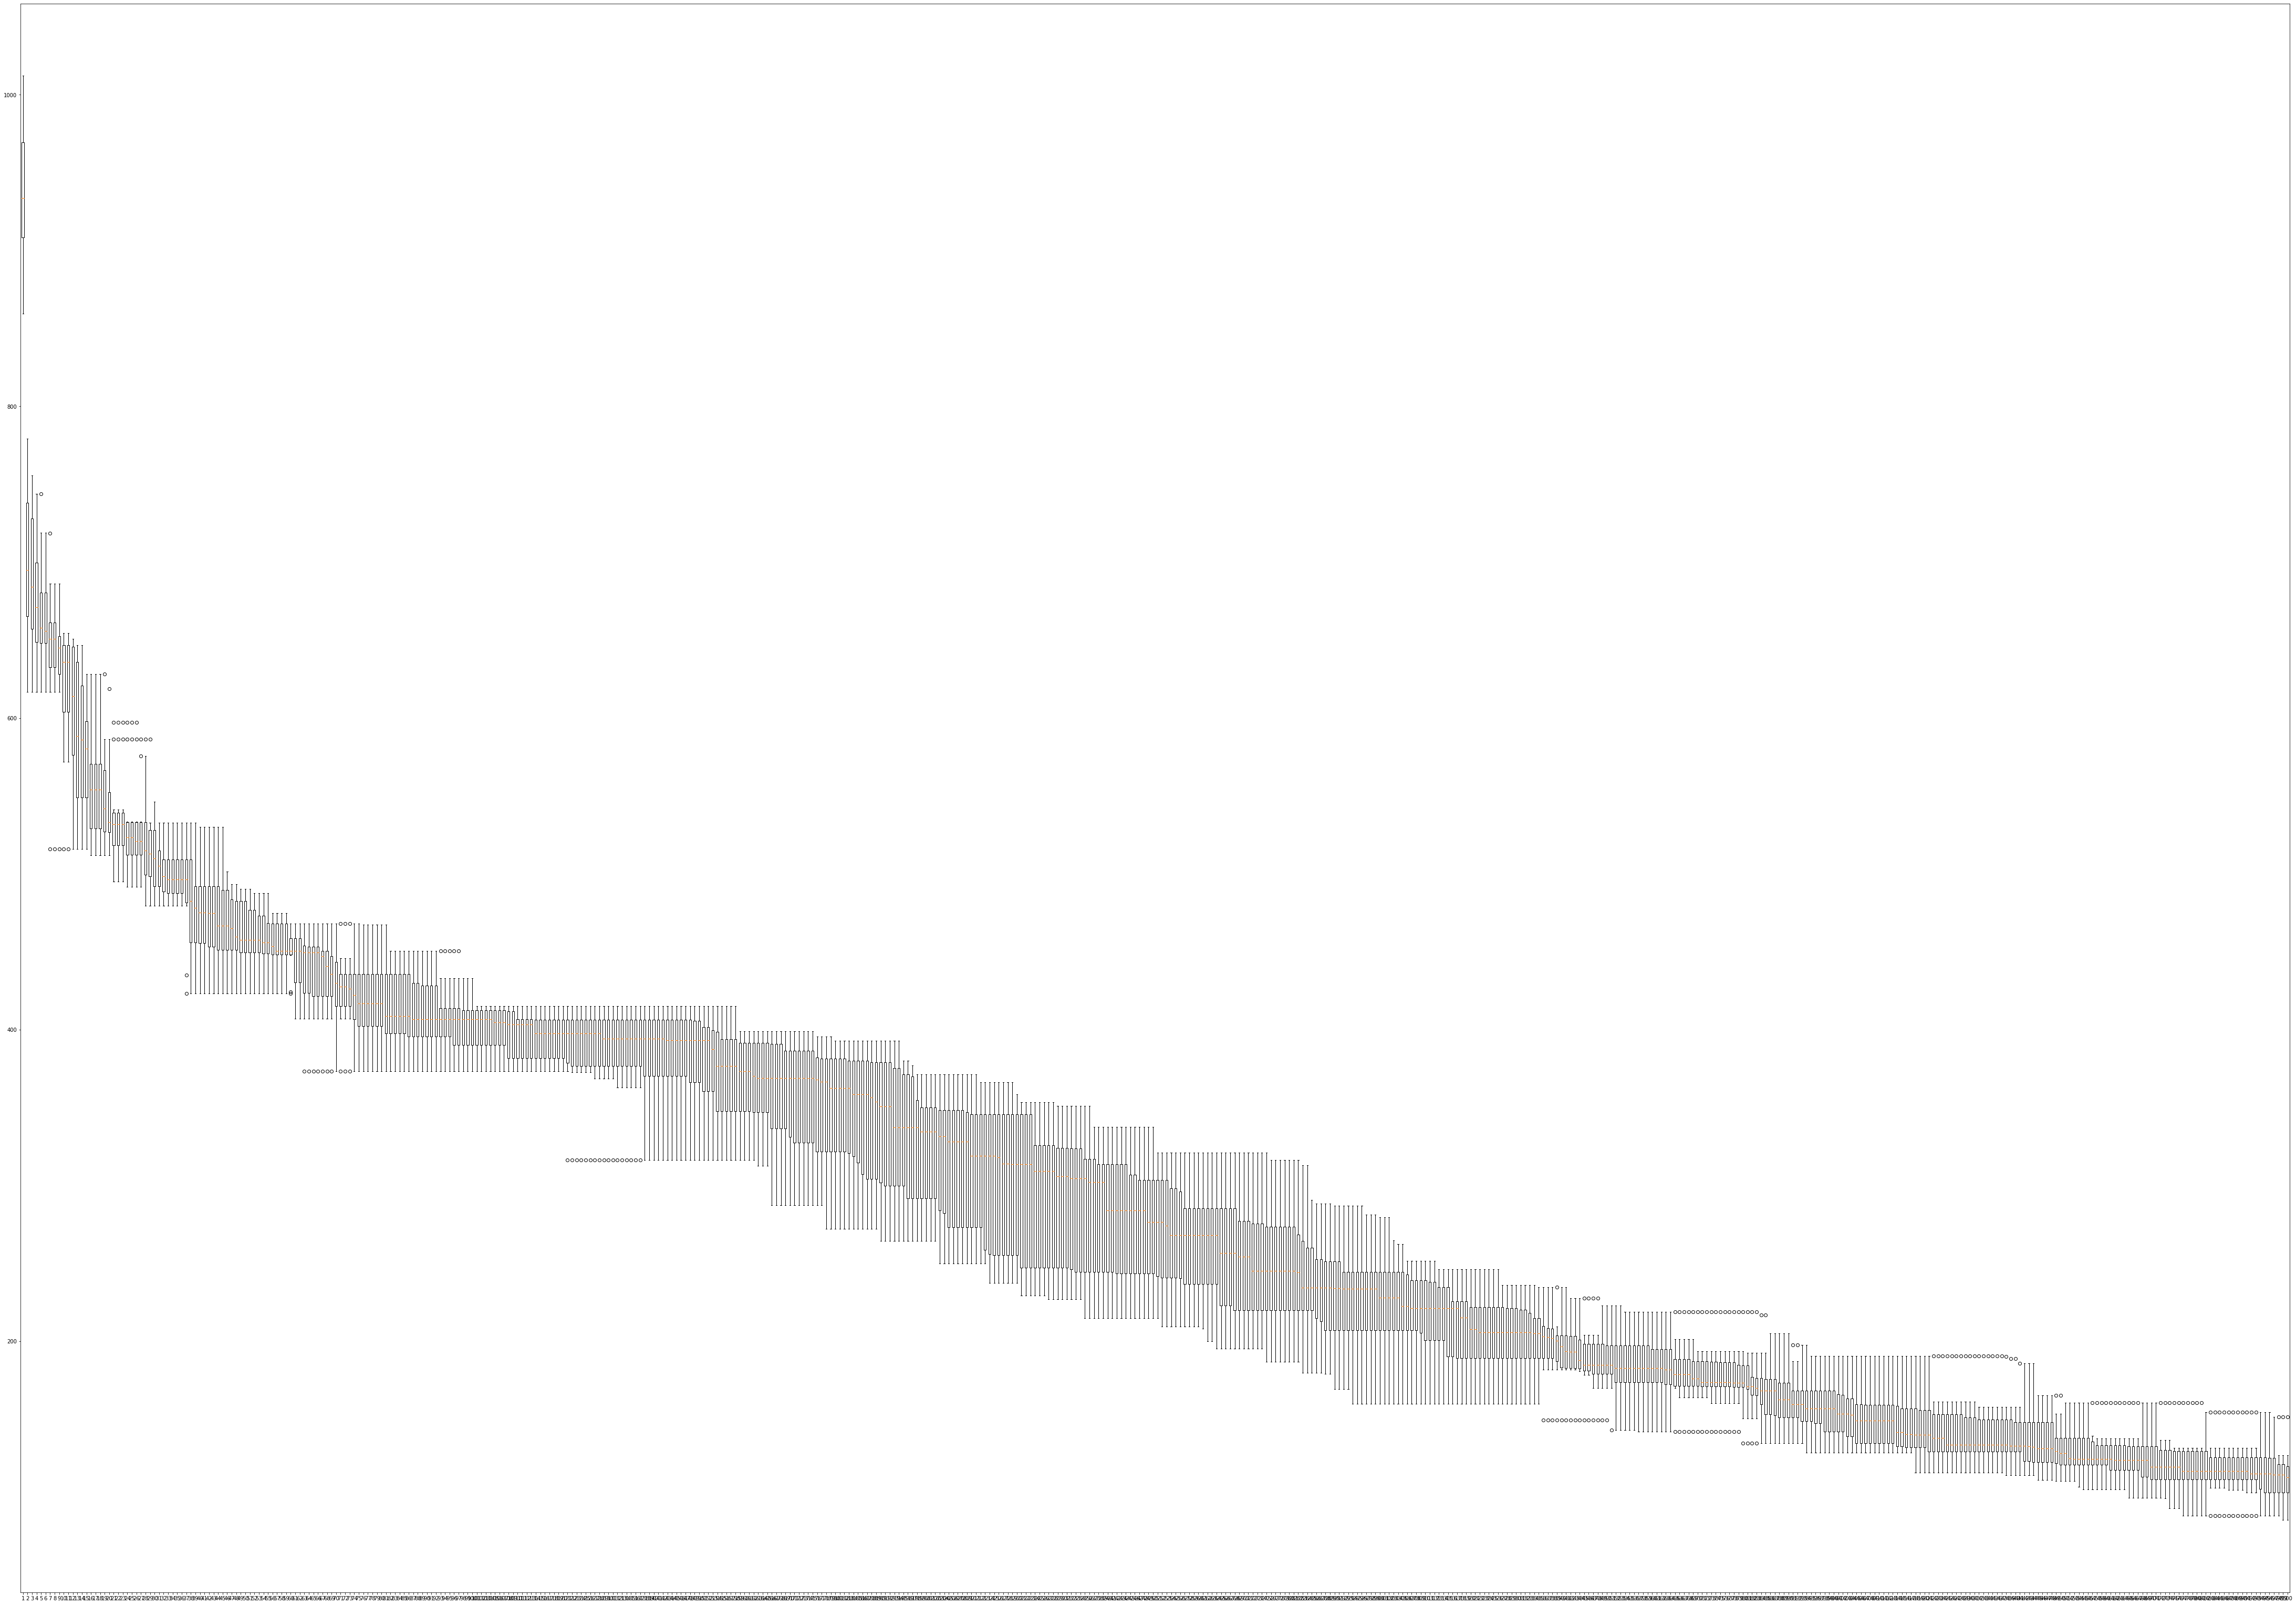

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


In [ ]:
evaluate(DifferentialEvolutionCrossover(CR=1.0, F=0.5, K=0.5))

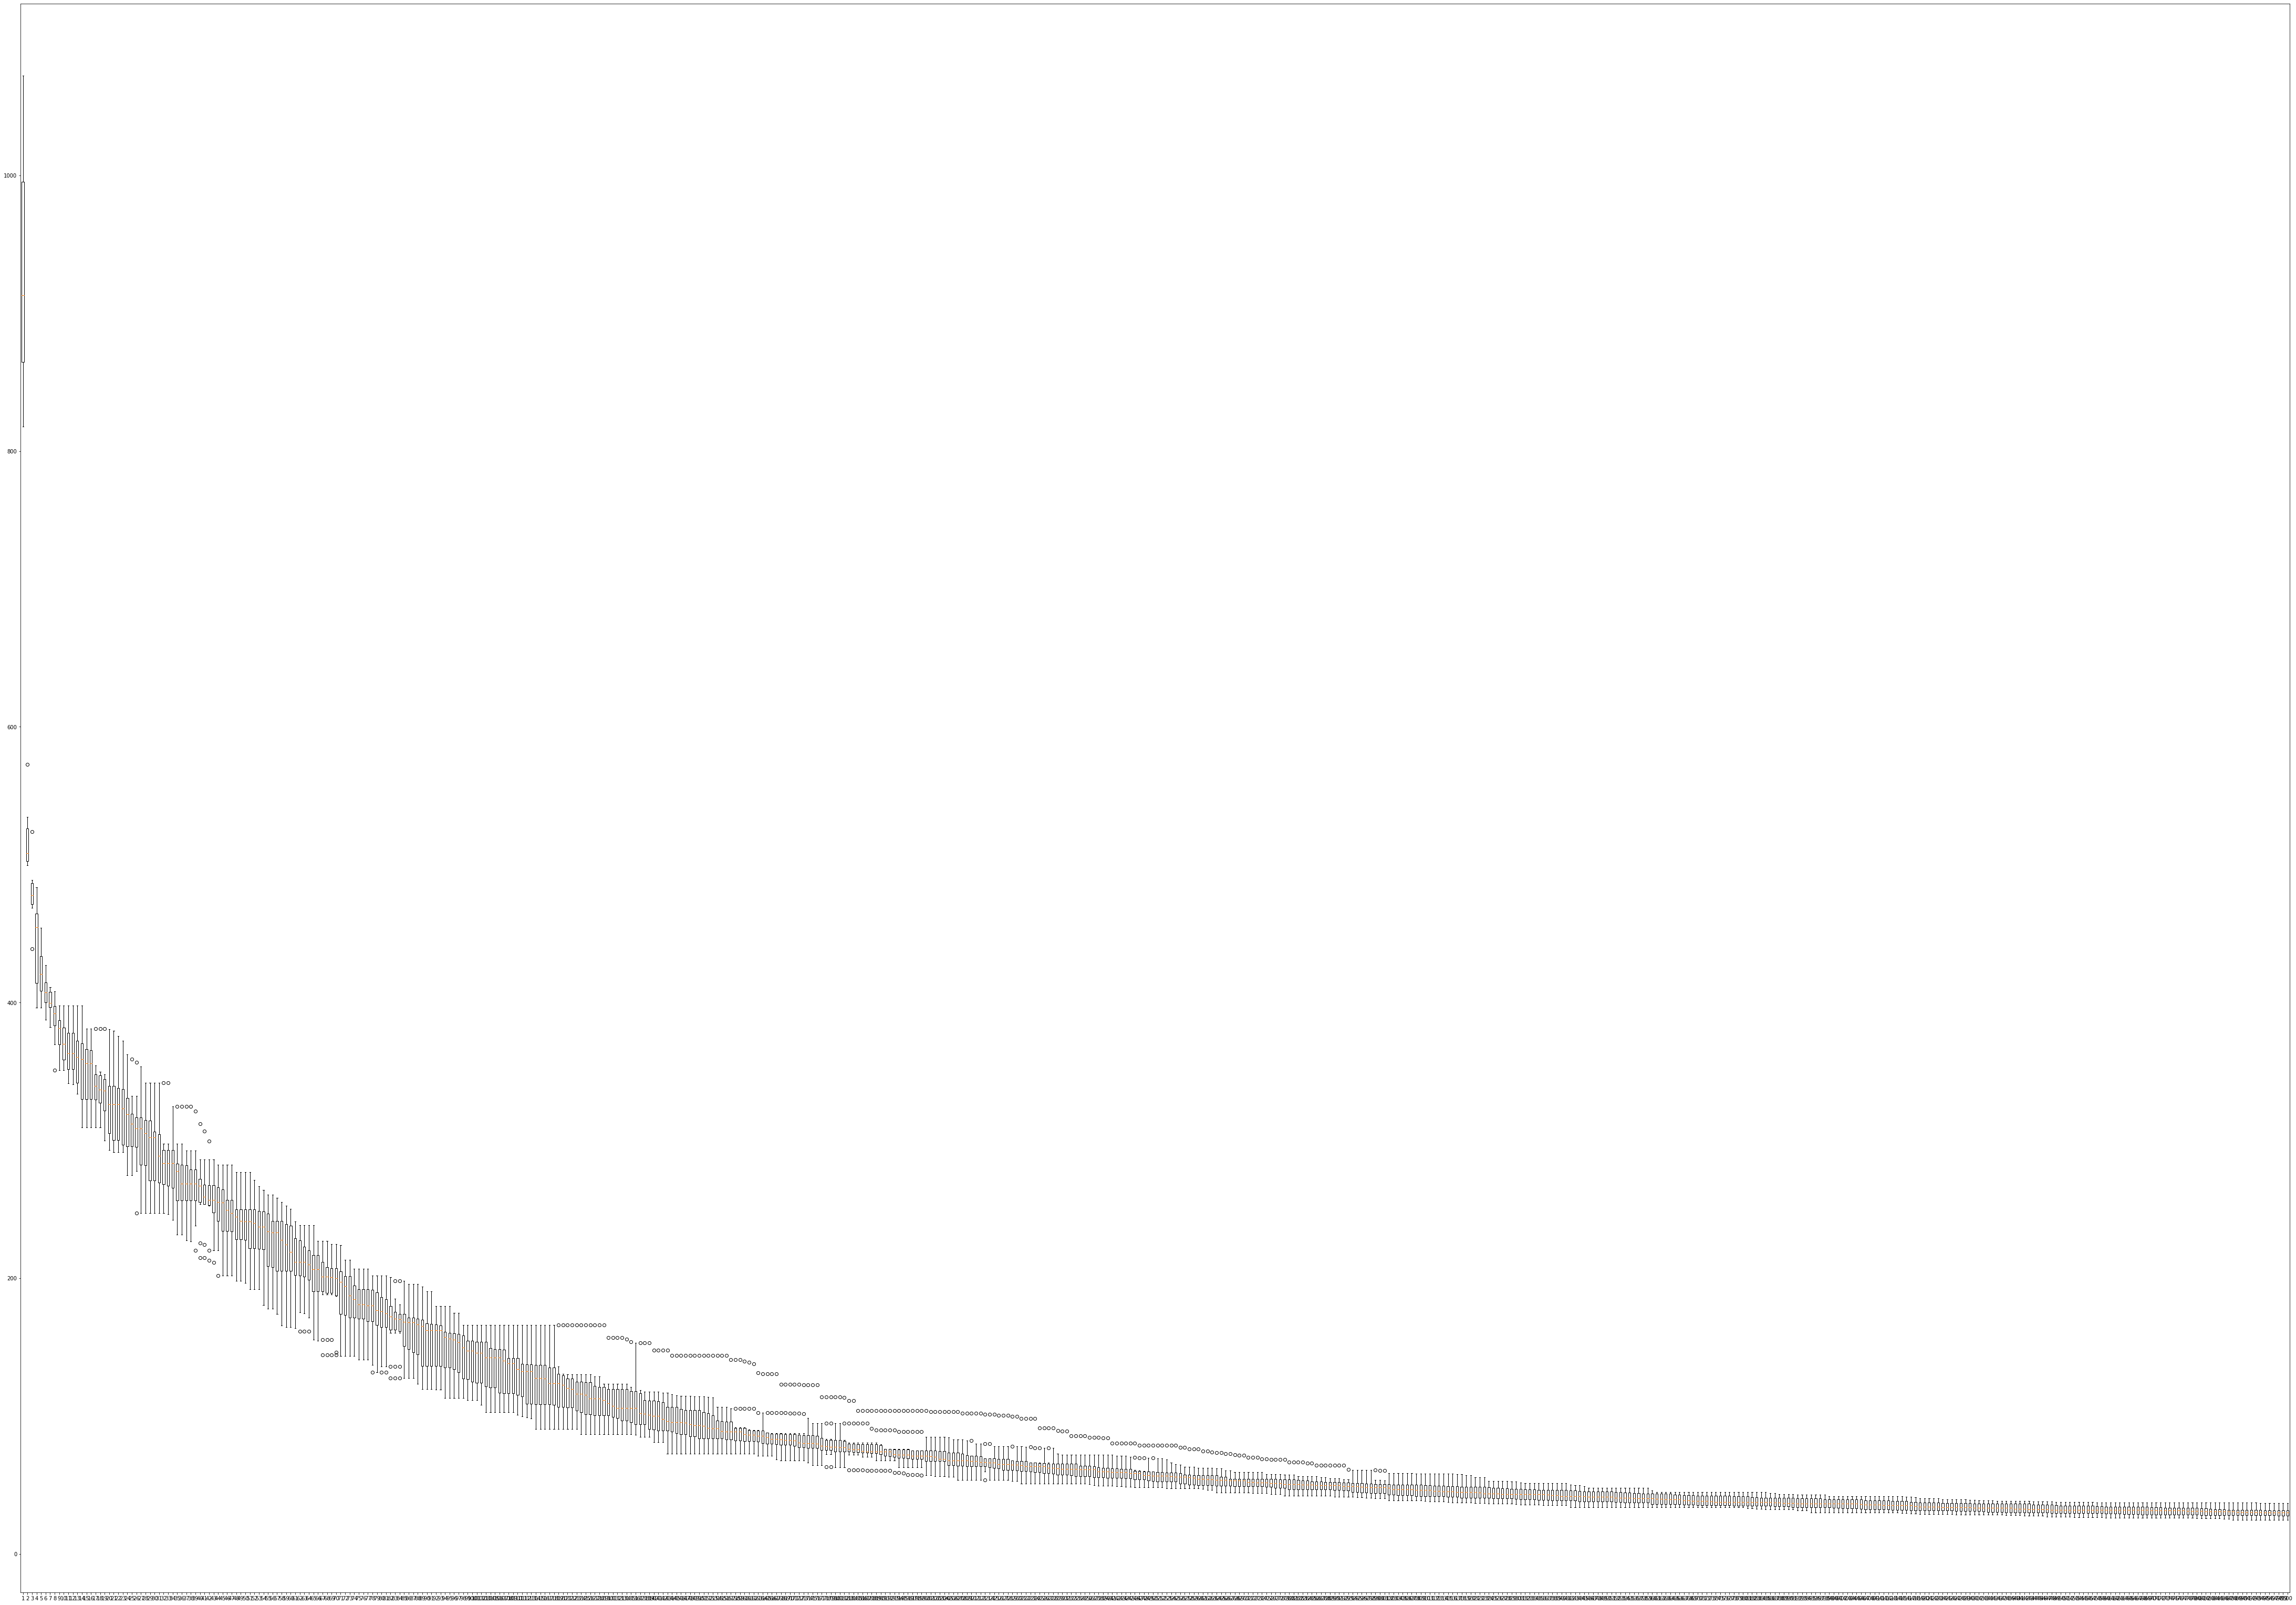

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


In [20]:
evaluate(SelectiveMultiParentCrossover(CR=1.0, F=0.5, K=0.5, PN=3))

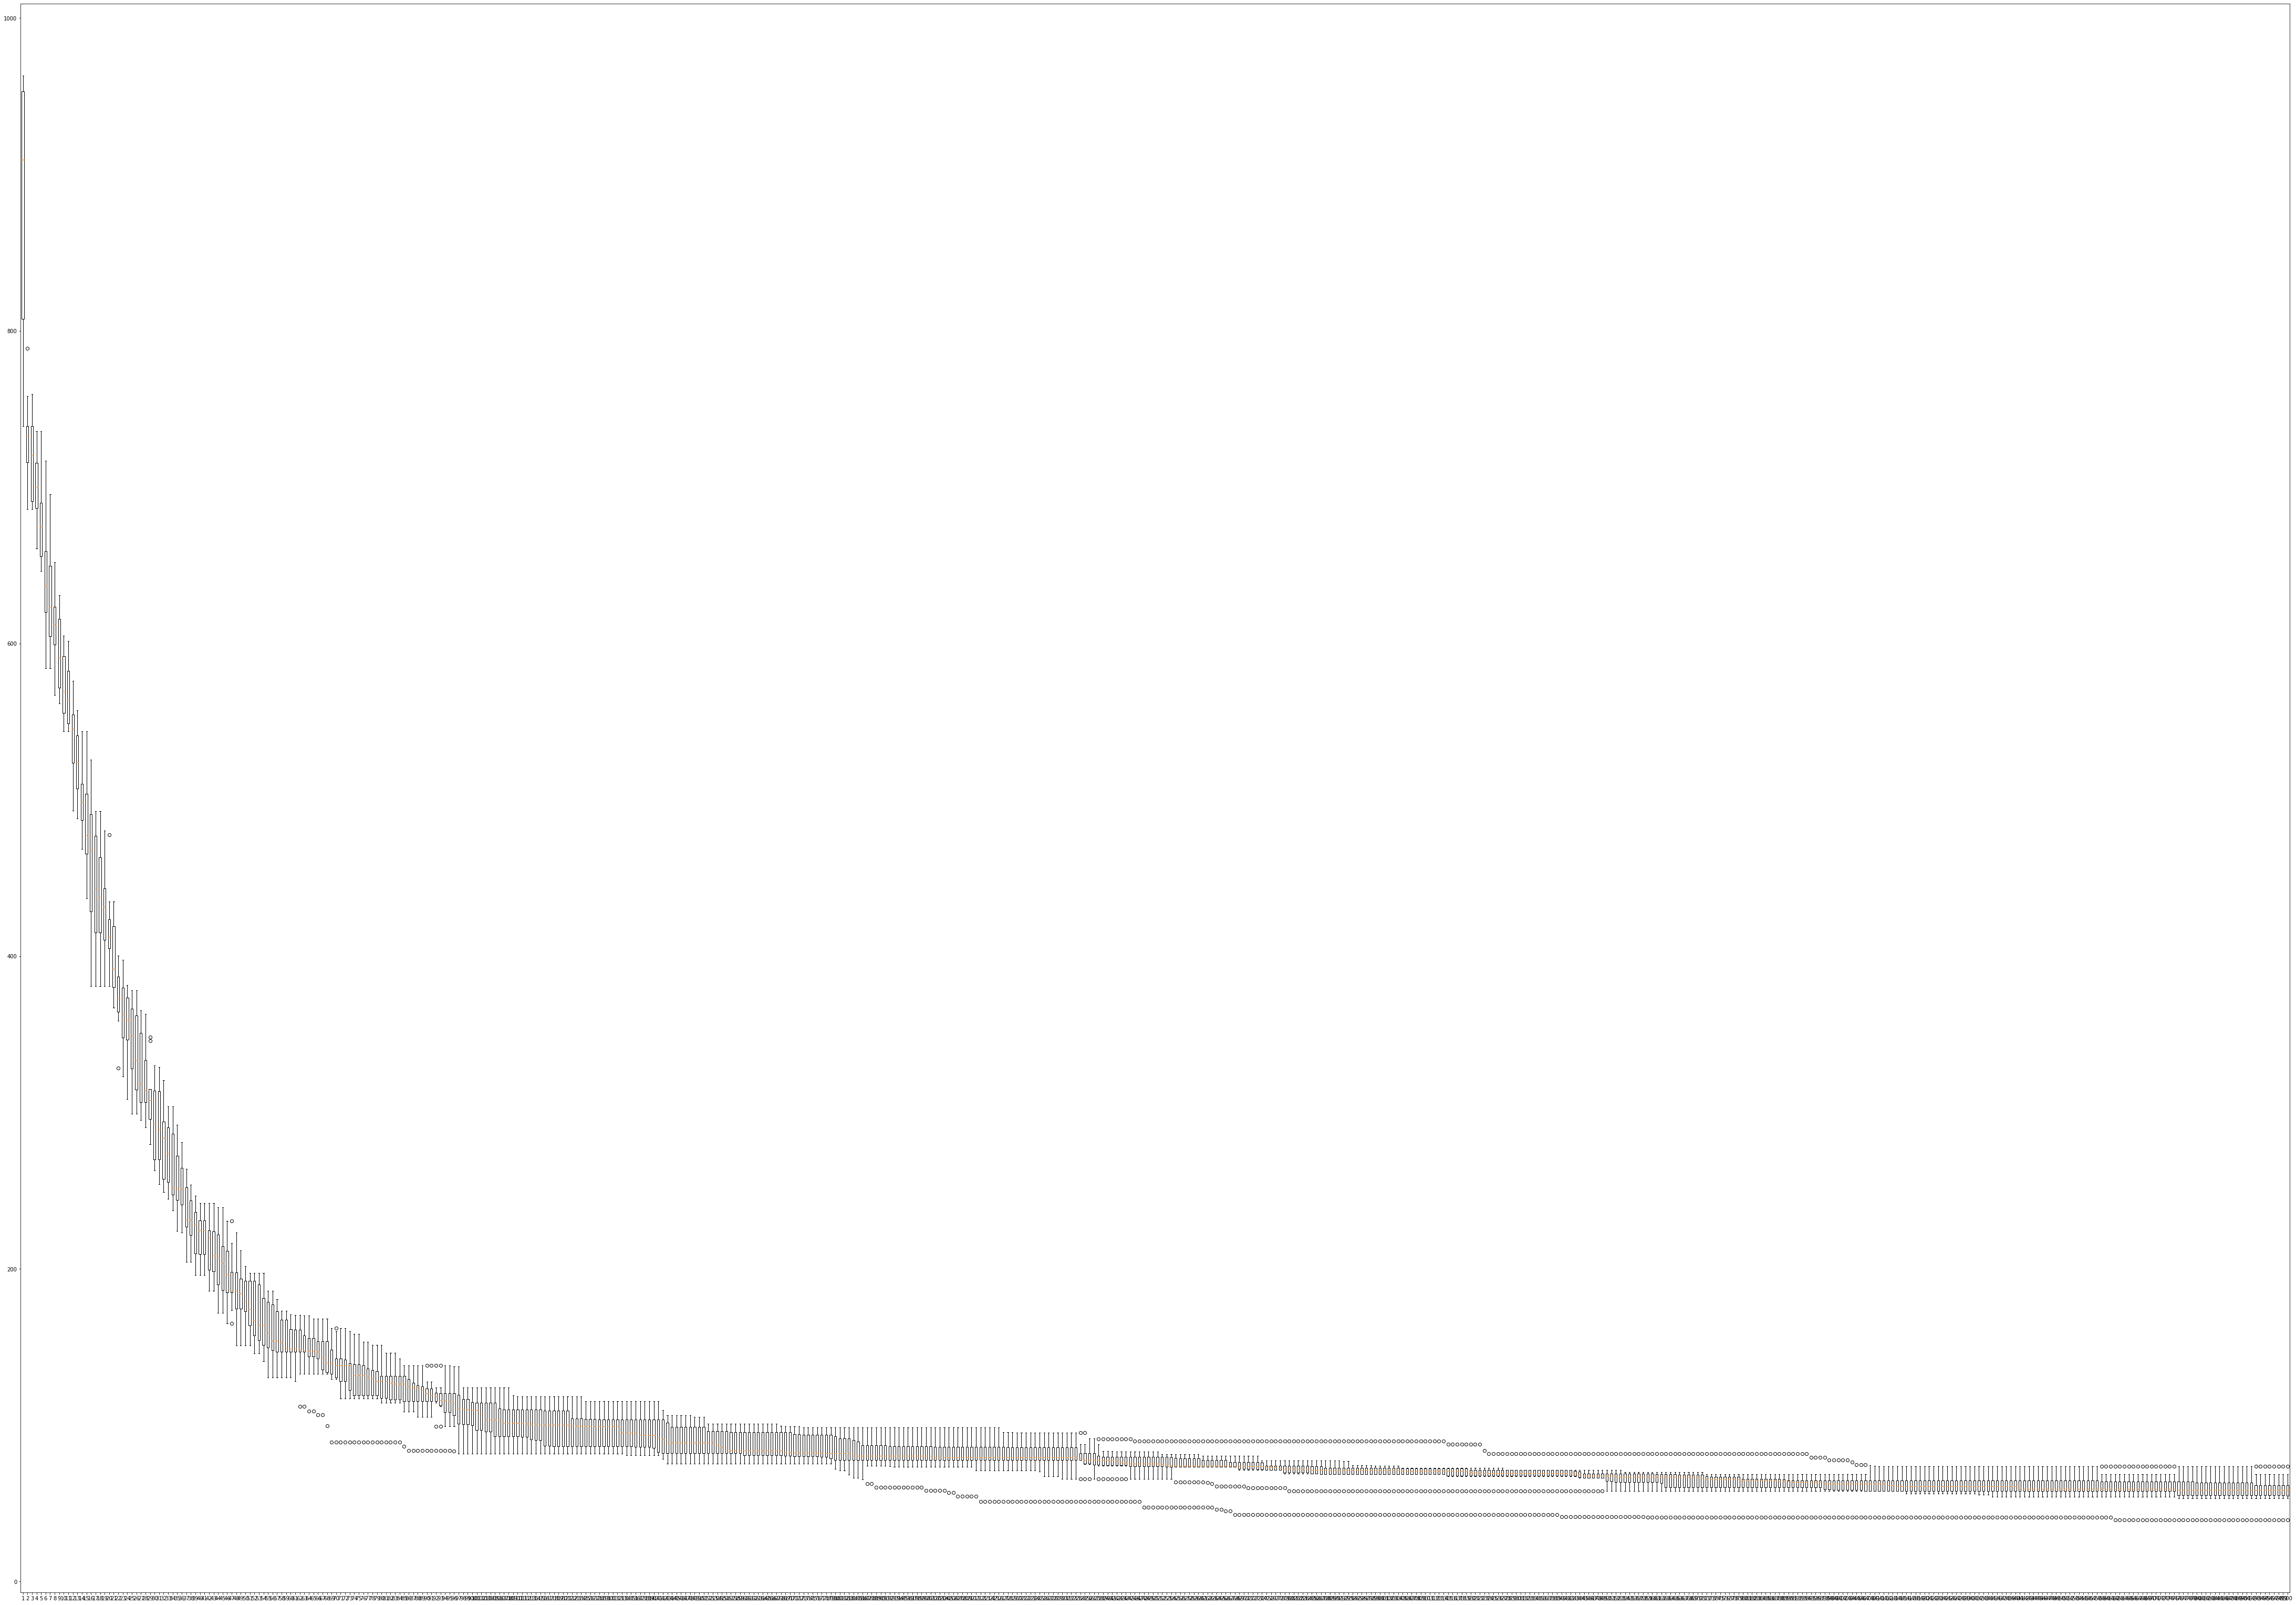

KruskalResult(statistic=24.702914997774805, pvalue=4.323447252145403e-06)


In [ ]:
evaluate(RandomMultiParentCrossoverWithStep(PN = 3))

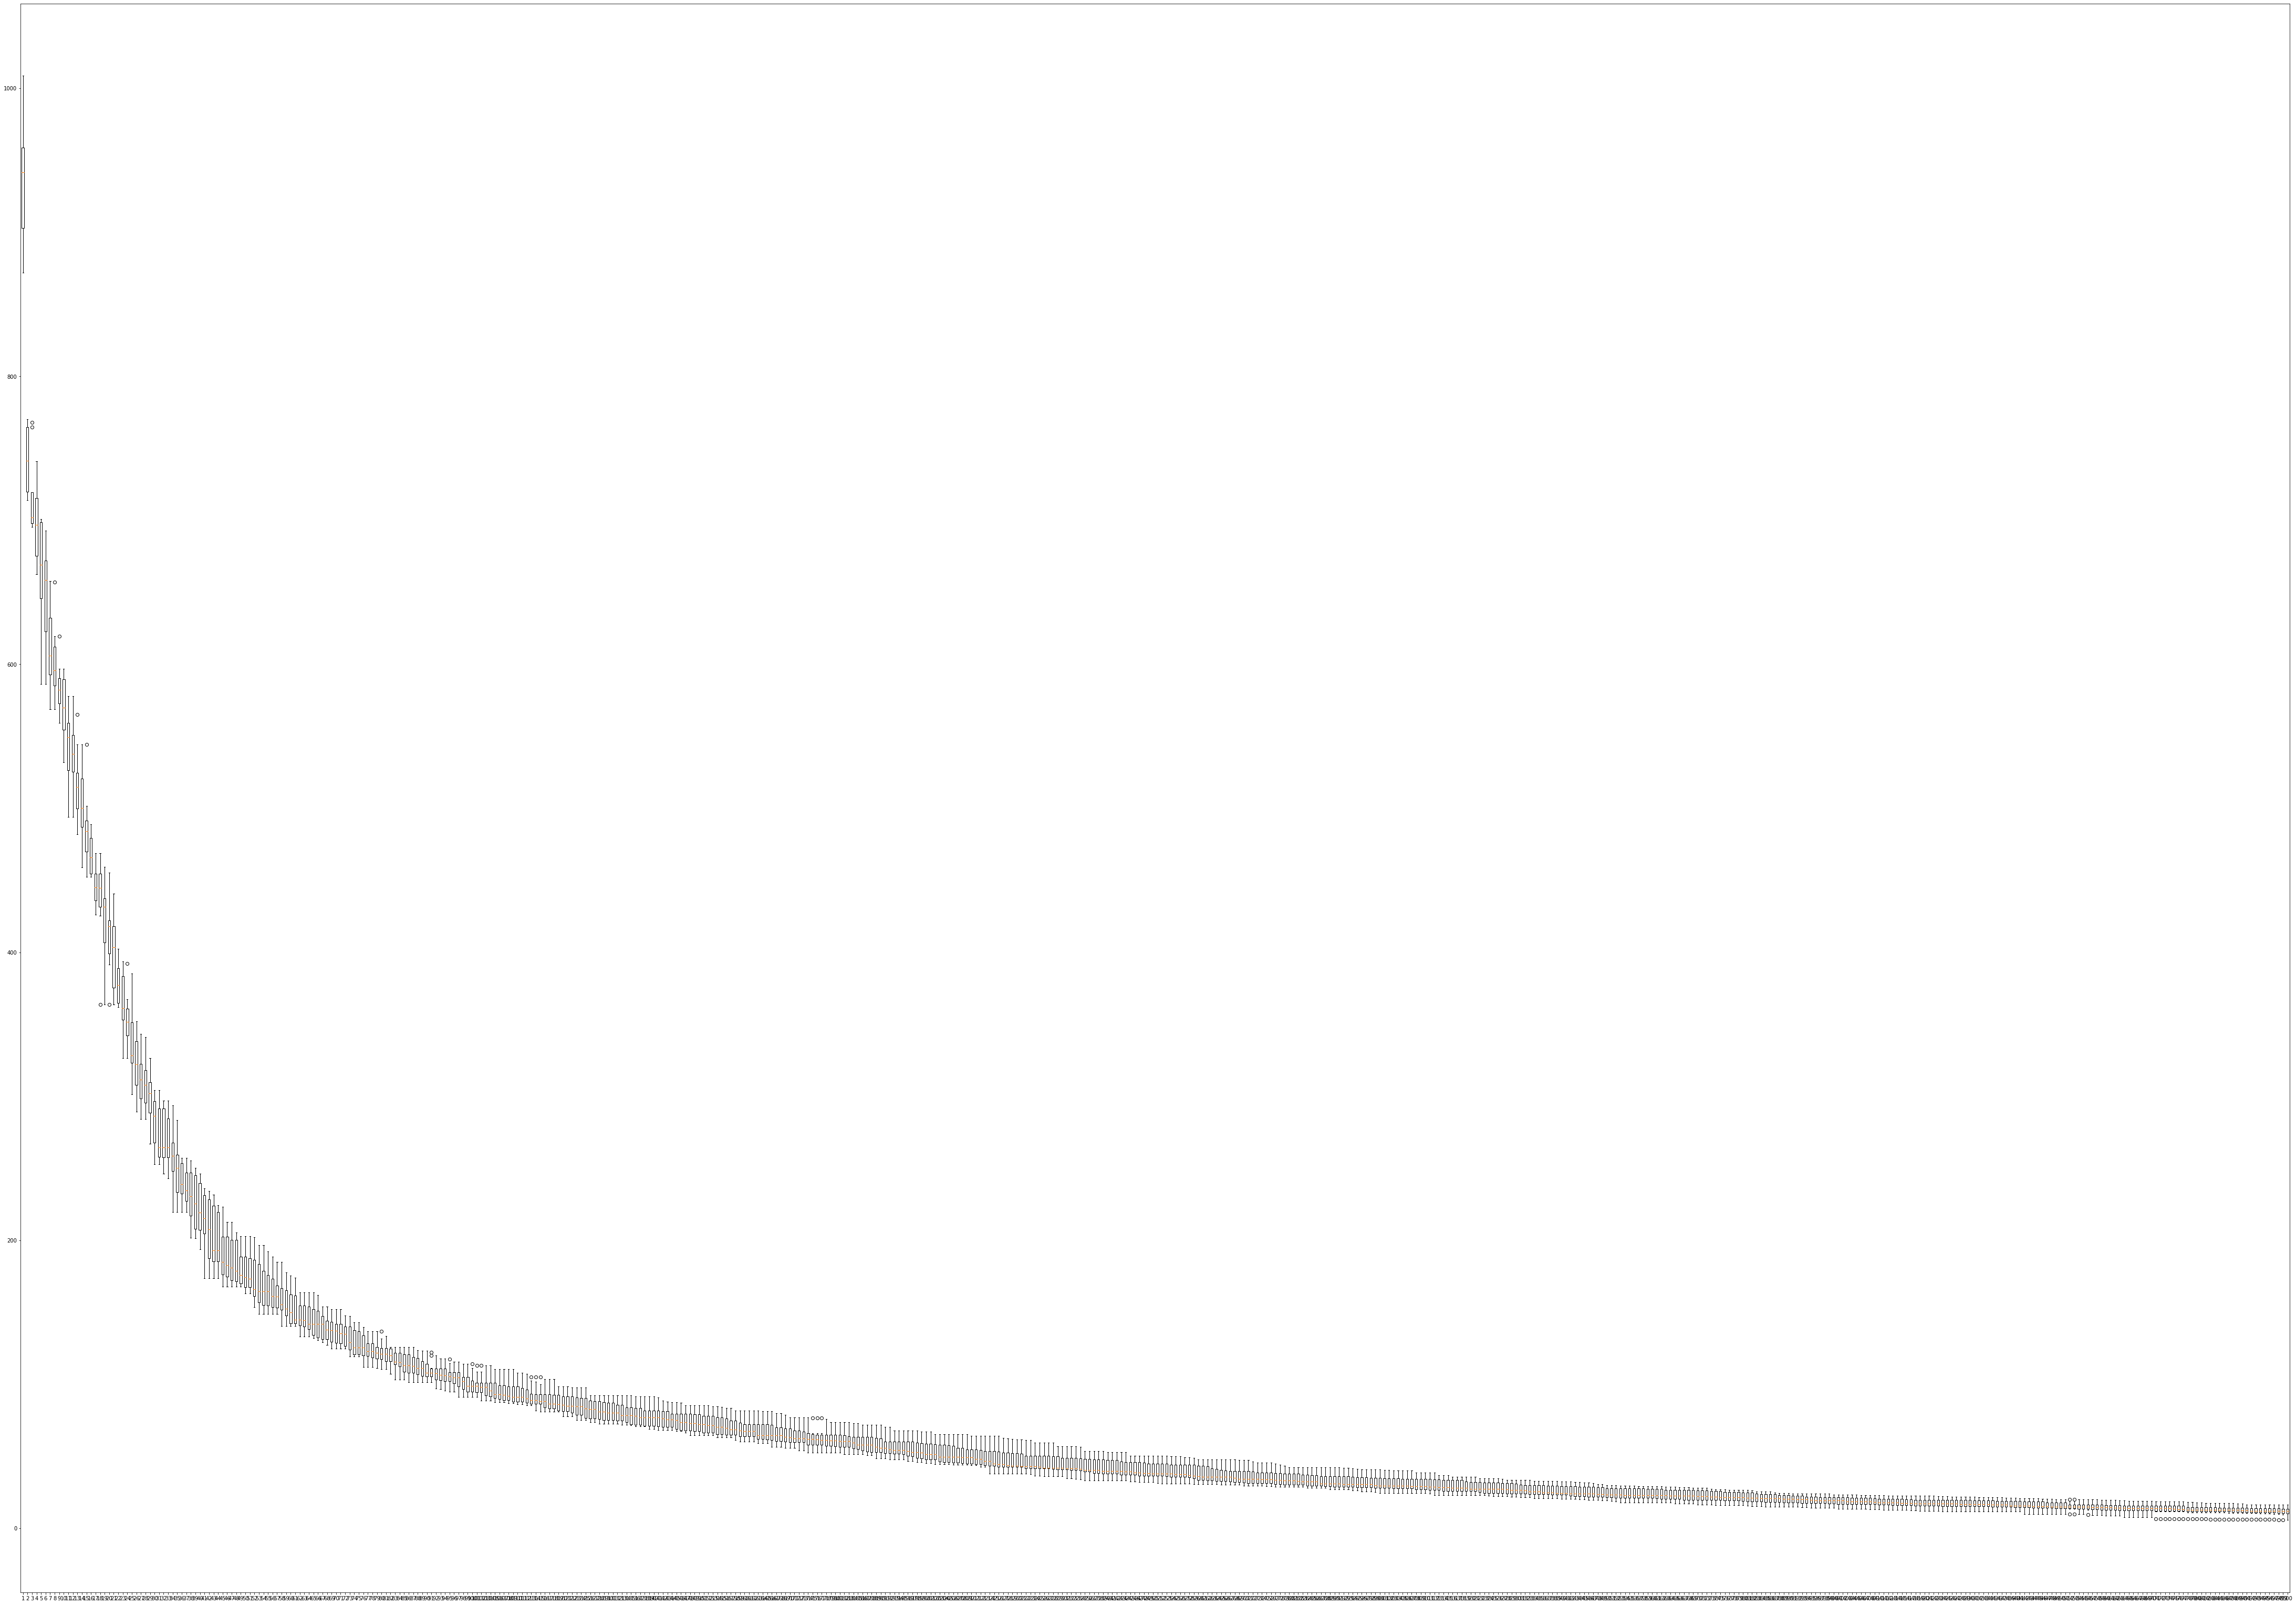

KruskalResult(statistic=25.80645161290323, pvalue=2.49000508218493e-06)


In [ ]:
evaluate(RandomMultiParentCrossover(PN = 3))